In [1]:
# -*- coding: utf-8 -*-

# --- 1. PREPARAÇÃO DO AMBIENTE ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Métricas de avaliação
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# --- 2. CARGA E LIMPEZA DE DADOS ---
# Carregando a base de dados diretamente do repositório do Kaggle no GitHub
# Usaremos apenas o arquivo de treino, que contém a variável alvo ('Survived')
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

print("--- Informações Iniciais do Dataset ---")
df.info()
print("\n--- Primeiras Linhas do Dataset ---")
print(df.head())

--- Informações Iniciais do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

--- Primeiras Linhas do Dataset ---
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         

In [3]:
# Tratando dados faltantes
# 'Age': Preencher com a mediana é uma abordagem robusta contra outliers
df['Age'] = df['Age'].fillna(df['Age'].median())

# 'Embarked': Preencher com a moda (o valor mais comum)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 'Cabin': Possui muitos valores nulos (quase 77%). A abordagem mais simples é remover a coluna.
# Poderíamos tentar extrair informação (como a primeira letra do deck), mas para este comparativo, vamos remover.
df.drop('Cabin', axis=1, inplace=True)

# Removendo colunas que não agregam valor preditivo direto para o modelo
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [4]:
# --- 3. PRÉ-PROCESSAMENTO E ENGENHARIA DE FEATURES ---
# Convertendo variáveis categóricas em variáveis numéricas (dummy variables)
# Usamos 'drop_first=True' para evitar multicolinearidade
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

print("\n--- Dataset Após Pré-processamento ---")
print(df.head())


--- Dataset Após Pré-processamento ---
   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500      True       False   
1         1       1  38.0      1      0  71.2833     False       False   
2         1       3  26.0      0      0   7.9250     False       False   
3         1       1  35.0      1      0  53.1000     False       False   
4         0       3  35.0      0      0   8.0500      True       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


In [5]:
# --- 4. DIVISÃO DOS DADOS ---
# Separando as variáveis independentes (features, X) da variável dependente (alvo, y)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Dividindo em conjuntos de treino e teste (80% para treino, 20% para teste)
# 'random_state' garante que a divisão seja sempre a mesma, para reprodutibilidade
# 'stratify=y' garante que a proporção de sobreviventes/não sobreviventes seja a mesma nos dois conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# --- 5. OTIMIZAÇÃO DE HIPERPARÂMETROS COM BUSCA BAYESIANA ---
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

print("--- Iniciando Otimização Bayesiana ---")

# --- Otimizador para a Árvore de Decisão ---
print("\nOtimizando a Árvore de Decisão...")

# Definindo o espaço de busca dos hiperparâmetros
search_space_dt = {
    'criterion': Categorical(['gini', 'entropy']),
    'max_depth': Integer(3, 50),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}

# Criando o otimizador Bayesiano
# n_iter: número de combinações de parâmetros a testar
# cv: número de folds para a validação cruzada
bayes_search_dt = BayesSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    search_spaces=search_space_dt,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Usar todos os processadores disponíveis
    random_state=42
)

# Executando a busca (usando apenas dados de treino para evitar data leakage)
bayes_search_dt.fit(X_train, y_train)

# Melhor modelo encontrado
best_dt_model = bayes_search_dt.best_estimator_
print(f"Melhores parâmetros para Árvore de Decisão: {bayes_search_dt.best_params_}")


# --- Otimizador para o Random Forest ---
print("\nOtimizando o Random Forest...")

# Definindo o espaço de busca
search_space_rf = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100),
    'max_features': Categorical(['sqrt', 'log2'])
}

# Criando o otimizador Bayesiano
bayes_search_rf = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    search_spaces=search_space_rf,
    n_iter=50, # Mais iterações, pois o espaço de busca é maior
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Executando a busca
bayes_search_rf.fit(X_train, y_train)

# Melhor modelo encontrado
best_rf_model = bayes_search_rf.best_estimator_
print(f"Melhores parâmetros para Random Forest: {bayes_search_rf.best_params_}")

--- Iniciando Otimização Bayesiana ---

Otimizando a Árvore de Decisão...
Melhores parâmetros para Árvore de Decisão: OrderedDict({'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 40, 'min_samples_split': 29})

Otimizando o Random Forest...
Melhores parâmetros para Random Forest: OrderedDict({'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 54})


In [8]:
# --- 6. AVALIAÇÃO DETALHADA ---

def evaluate_model(model_name, y_true, y_pred):
    """Função para exibir as métricas de avaliação de forma organizada."""
    print(f"--- Avaliação do Modelo: {model_name} ---")
    
    # Acurácia Geral
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Acurácia Geral: {accuracy:.4f}\n")
    
    # Relatório de Classificação (com métricas por classe)
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=['Não Sobreviveu (0)', 'Sobreviveu (1)']))
    
    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Sobreviveu', 'Sobreviveu'], 
                yticklabels=['Não Sobreviveu', 'Sobreviveu'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()
 

--- Avaliação do Modelo: Árvore de Decisão Otimizada ---
Acurácia Geral: 0.7933

Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.77      0.95      0.85       110
    Sobreviveu (1)       0.86      0.55      0.67        69

          accuracy                           0.79       179
         macro avg       0.82      0.75      0.76       179
      weighted avg       0.81      0.79      0.78       179



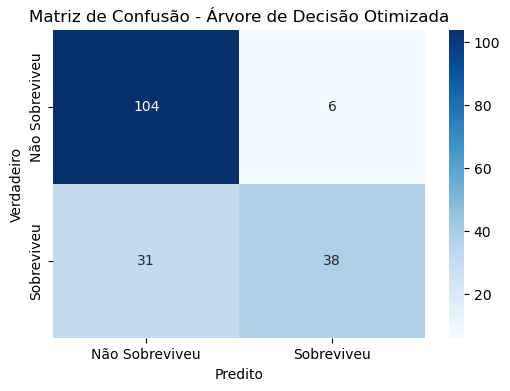

--- Avaliação do Modelo: Random Forest Otimizado ---
Acurácia Geral: 0.8045

Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.79      0.94      0.85       110
    Sobreviveu (1)       0.85      0.59      0.70        69

          accuracy                           0.80       179
         macro avg       0.82      0.77      0.78       179
      weighted avg       0.81      0.80      0.80       179



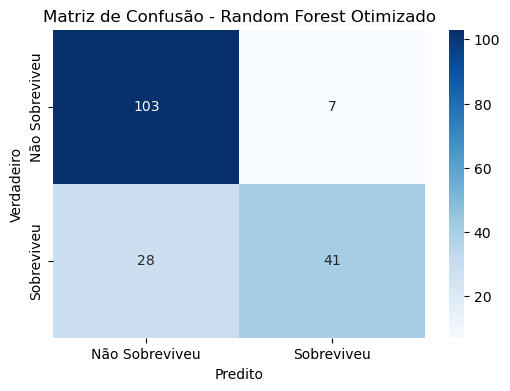

In [9]:
# --- 7. AVALIAÇÃO DOS MODELOS OTIMIZADOS ---

# Previsões com os melhores modelos encontrados
y_pred_dt_optimized = best_dt_model.predict(X_test)
y_pred_rf_optimized = best_rf_model.predict(X_test)

# Reutilizando a função de avaliação

# Avaliando a Árvore de Decisão Otimizada
evaluate_model("Árvore de Decisão Otimizada", y_test, y_pred_dt_optimized)

# Avaliando o Random Forest Otimizado
evaluate_model("Random Forest Otimizado", y_test, y_pred_rf_optimized)